# Esercitazione 2
Scopo dell'esercitazione è quello di sintetizzare un suono attraverso l'uso delle formanti e dei corrispondenti poli

Inizialmente possiamo partire dai poli direttamente. Sappiamo che possiamo realizzare la funzione di trasferimento a partire dai ppoli, considerando quindi i coefficienti reali e infine facendo il prodotto di convoluzione

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# I poli forniti
p1 = 0.963 + 0.116j
p2 = 0.619 + 0.719j
p3 = 0.370 + 0.874j

/home/gabriele/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
# definisco anche frequenza di campionamento della forma d'onda e numero di punti su cui calcolare la DFT
fs = 16e3 # 16 Khz
n_fft = 1024
f0 = 100

Adesso considero che posso definire la funzione di trasferimento come:
```math
H(z) = \frac{1}{(1-p1)(1-p1^{*})}
```
Dunque devo fare il prodotto di convoluzione tra le tre funzioni di trasferimento, ognuna associata al polo complesso coniugato corrispondente

In [39]:
a_1 = np.convolve(np.array([1, -p1]), np.array([1, -p1.conjugate()]))
a_2 = np.convolve(np.array([1, -p2]), np.array([1, -p2.conjugate()]))
a_3 = np.convolve(np.array([1, -p3]), np.array([1, -p3.conjugate()]))

Adesso considero la proprietà tempo varianza dei sistemi LTI:
```math
H(z) = H(z)_{p1} * H(z)_{p2} * H(z)_{p3}
```

In [40]:
a = np.convolve(np.convolve(a_1, a_2), a_3)

Oppure potevo idealmente usare la funzione poly che permette di realizzare un polinomio:

In [41]:
# Creo il filtro dai poli
def create_filter_from_poles(poles, gain=1.0):
    # Costruisco il polinomio del denominatore dai poli
    a = np.real(np.poly(poles))
    # Per un filtro solo-poli, il numeratore è semplicemente il guadagno
    b = [gain]
    return b, a

# Aggiungo i coniugati complessi per avere un filtro con coefficienti reali
poles = [p1, np.conjugate(p1), p2, np.conjugate(p2), p3, np.conjugate(p3)]
b, a = create_filter_from_poles(poles)
print(f"Roots: {np.roots(a)}")

Roots: [0.37 +0.874j 0.37 -0.874j 0.619+0.719j 0.619-0.719j 0.963+0.116j
 0.963-0.116j]


Stampiamo dunque le radici del denominatore della funzione di trasferimento e plottiamo la risposta in frequenza. Le radici dovrebbero essere i poli

In [9]:
print(f"Roots: ", np.roots(a))

Roots:  [0.37 +0.874j 0.619+0.719j 0.963+0.116j 0.963-0.116j 0.37 -0.874j
 0.619-0.719j]


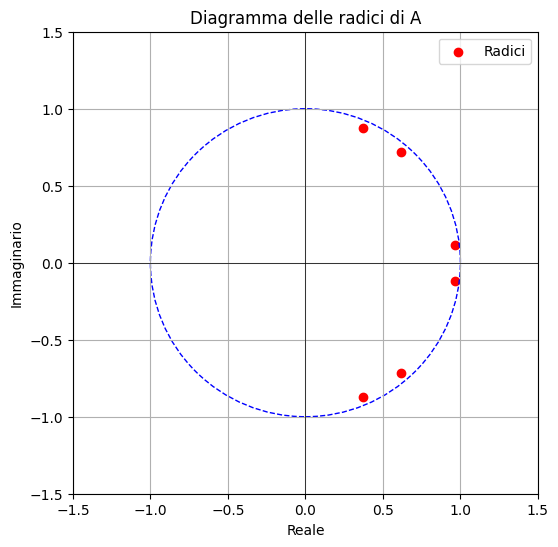

In [42]:
# Calcolo e plot delle radici di A
roots = np.roots(a)
plt.figure(figsize=(6, 6))
plt.scatter(np.real(roots), np.imag(roots), marker='o', color='red', label='Radici')
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dashed')
plt.gca().add_patch(circle)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Reale")
plt.ylabel("Immaginario")
plt.title("Diagramma delle radici di A")
plt.legend()
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

In [43]:
from scipy.signal import freqz 
from scipy.signal import lfilter

In [44]:
w, h = freqz(1,a,n_fft) # la funzione freqz calcola la risposta in frequenza di un filtro digitale
# ritorna le frequenze angolari normalizzate w e le risposte in frequenza
frequencies = w * fs / (2 * np.pi) # w sono le frequenze normalizzate in radianti, dobbiamo riportarci alle frequenze in Hz

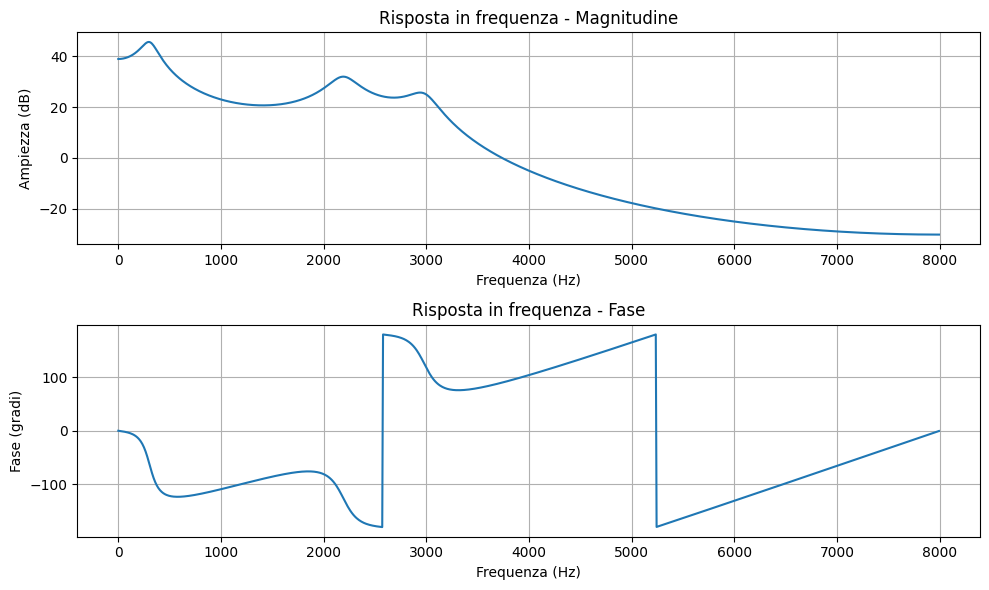

In [45]:
# Plot della risposta in frequenza
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Magnitudine
ax[0].plot(frequencies, 20 * np.log10(abs(h)))
ax[0].set_title("Risposta in frequenza - Magnitudine")
ax[0].set_xlabel("Frequenza (Hz)")
ax[0].set_ylabel("Ampiezza (dB)")
ax[0].grid()

# Fase
ax[1].plot(frequencies, np.angle(h, deg=True))
ax[1].set_title("Risposta in frequenza - Fase")
ax[1].set_xlabel("Frequenza (Hz)")
ax[1].set_ylabel("Fase (gradi)")
ax[1].grid()

plt.tight_layout()
plt.show()

Lo step successivo è quello di sintetizzare il suono, quindi scegliamo una frequenza fondamentale in Hz, pari per esempio alla frequenza di risonanza di un uomo o una donna.
Dopodiché gli step per sintetizzare il suono sono:
- generare un treno di impulsi 
- creare un filtro lineare dove definiamo le radici del polinomio (i poli) e facciamo passare l'input
- quindi siamo in grado di plottare la parte reale 

In [66]:
f0 = 120
T = 2.0 # durata di 2 secondi

# Genera l'eccitazione (treno di impulsi per la voce vocalizzata)
t = np.arange(0, T, 1/fs) # treno di impulsi di durata T campionati con fs
n_samples = len(t)
pitch_period = int(fs / f0)  # periodo in campioni
excitation = np.zeros(n_samples)
for i in range(0, n_samples, pitch_period):
    if i < n_samples:
        excitation[i] = 1.0

In [47]:
# # Plot del treno di impulsi
# plt.figure(figsize=(10, 4))
# plt.stem(t, excitation)  # Mostriamo solo i primi impulsi
# plt.xlabel("Tempo (s)")
# plt.ylabel("Ampiezza")
# plt.title("Treno di impulsi per la voce vocalizzata")
# plt.grid()
# plt.show()

In [67]:
# Applica il filtro all'eccitazione
y = lfilter(b, a, excitation) # prende in input il guadagno (o una lista di guadagni), il filtro e il treno di impulsi
y = np.real(y)

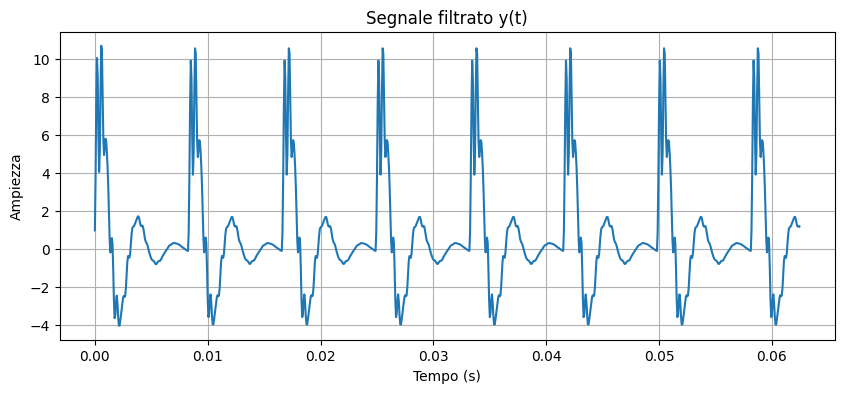

In [68]:
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], y[:1000])  # Show the first 400 samples for better visualization
plt.xlabel("Tempo (s)")
plt.ylabel("Ampiezza")
plt.title("Segnale filtrato y(t)")
plt.grid()
plt.show()

In [76]:
import sounddevice as sd
sd.play(y.squeeze(), fs)
sd.wait()

In [79]:
def scala_frequenze(f0s,a,b):
    for f0 in f0s:
        # Genera l'eccitazione (treno di impulsi per la voce vocalizzata)
        t = np.arange(0, T, 1/fs) # treno di impulsi di durata T campionati con fs
        n_samples = len(t)
        pitch_period = int(fs / f0)  # periodo in campioni
        excitation = np.zeros(n_samples)
        for i in range(0, n_samples, pitch_period):
            if i < n_samples:
                excitation[i] = 1.0
        # Applica il filtro all'eccitazione
        y = lfilter(b, a, excitation) # prende in input il guadagno (o una lista di guadagni), il filtro e il treno di impulsi
        y = np.real(y)
        sd.play(y.squeeze(), fs)
        sd.wait(1)

scala_frequenze([60, 80, 100, 120], a,b)


Come possiamo notare, il segnale che ne viene fuori dal filtro è ben lontano dal treno di impulsi che abbiamo progettato, tuttavia notiamo come siamo riusciti a filtrare il treno di impulsi come se fosse un filtro passa basso, andando ad attenuare solo alcue frequenze. Notiamo infine come il pitch è di circa 0.01 ms, quindi appunto 100 Hz


Calcoliamo adesso la DFT per passare nel dominio della frequenza e visualizzare lo spettro

In [81]:
Y = np.fft.fft(y.squeeze(), n_fft)
frequencies = np.fft.fftfreq(n_fft, d=1/fs) # d definisce lo step, che nel nostro caso permette di riportarci alle frequenze normalizzate in Hz
positive_freqs = frequencies[:n_fft // 2] # la DFT per un segnale reale è complessa coniugata, quindi simmetrica, quindi prendiamo l'ultima parte
magnitude_spectr = np.log(np.abs(Y[:n_fft // 2]))

In [82]:
print(f"Positive freqs: {positive_freqs.shape}")
print(f"Magnitude: {magnitude_spectr.shape}")

Positive freqs: (512,)
Magnitude: (512,)


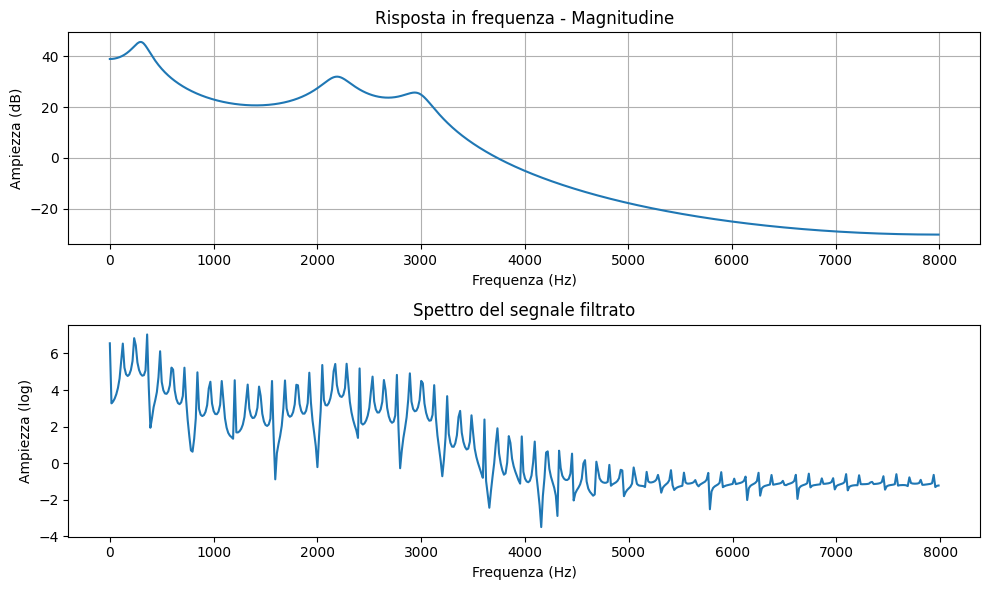

In [88]:
# Plot della risposta in frequenza
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# ricopio per il segnale del fltro digitale
w, h = freqz(1,a,n_fft) # la funzione freqz calcola la risposta in frequenza di un filtro digitale
# ritorna le frequenze angolari normalizzate w e le risposte in frequenza
frequencies = w * fs / (2 * np.pi) 
# w sono le frequenze normalizzate in radianti, dobbiamo riportarci alle frequenze in Hz

# Magnitudine
ax[0].plot(frequencies, 20 * np.log10(abs(h)))
ax[0].set_title("Risposta in frequenza - Magnitudine")
ax[0].set_xlabel("Frequenza (Hz)")
ax[0].set_ylabel("Ampiezza (dB)")
ax[0].grid()

# Plotting the frequency spectrum
ax[1].plot(positive_freqs, magnitude_spectr)
ax[1].set_xlabel("Frequenza (Hz)")
ax[1].set_ylabel("Ampiezza (log)")
ax[1].set_title("Spettro del segnale filtrato")
ax[1].grid()

plt.tight_layout()
plt.grid()
plt.show()

In [99]:
def freq_response_plot(a, n_fft, fs, y):
    w, h = freqz(1,a,n_fft) # la funzione freqz calcola la risposta in frequenza di un filtro digitale
    # ritorna le frequenze angolari normalizzate w e le risposte in frequenza
    frequencies_h = w * fs / (2 * np.pi) # w sono le frequenze normalizzate in radianti, dobbiamo riportarci alle frequenze in Hz
    Y = np.fft.fft(y.squeeze(), n_fft)
    frequencies = np.fft.fftfreq(n_fft, d=1/fs) # d definisce lo step, che nel nostro caso permette di riportarci alle frequenze normalizzate in Hz
    positive_freqs = frequencies[:n_fft // 2] # la DFT per un segnale reale è complessa coniugata, quindi simmetrica, quindi prendiamo l'ultima parte
    magnitude_spectr = np.log(np.abs(Y[:n_fft // 2]))
    # Plot della risposta in frequenza
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    # Magnitudine
    ax[0].plot(frequencies_h, 20 * np.log10(abs(h)))
    ax[0].set_title("Risposta in frequenza - Magnitudine")
    ax[0].set_xlabel("Frequenza (Hz)")
    ax[0].set_ylabel("Ampiezza (dB)")
    ax[0].grid()
    # Plotting the frequency spectrum
    ax[1].plot(positive_freqs, magnitude_spectr)
    ax[1].set_xlabel("Frequenza (Hz)")
    ax[1].set_ylabel("Ampiezza (log)")
    ax[1].set_title("Spettro del segnale filtrato")
    ax[1].grid()
    plt.tight_layout()
    plt.grid()
    plt.show()

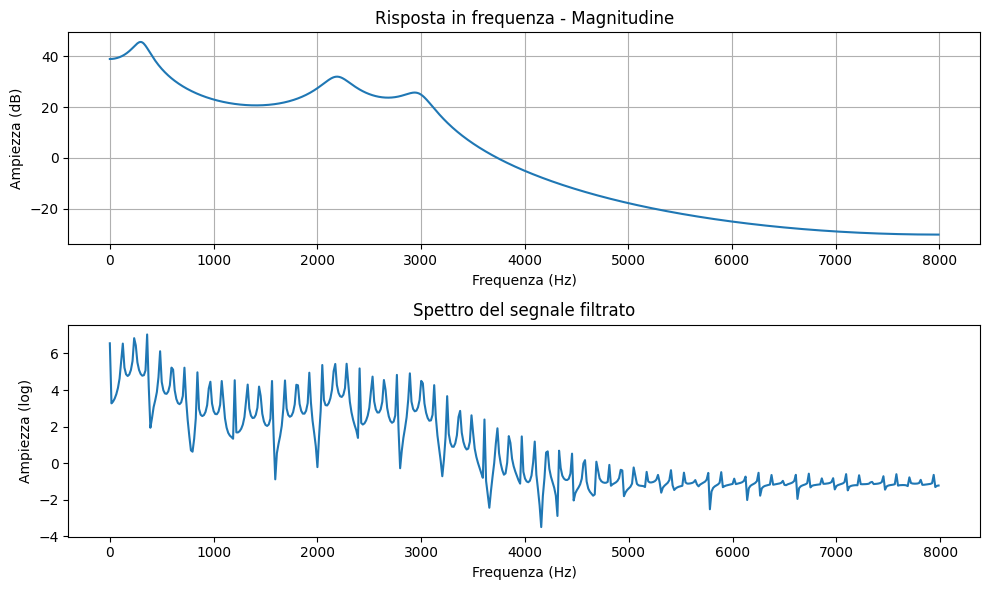

In [100]:
freq_response_plot(a,n_fft, fs, y)

Come possiamo notare, il segnale filtrato mette in evidenza i pitch

# Esercizio 2
Adesso partiamo dalle formanti per raggiungere i poli. Ricordiamo che, a partire della formanti, possiamo determinare un polo (e il suo conseguente complesso coniugato) andando a considerare modulo e fase:
Adesso considero la proprietà tempo varianza dei sistemi LTI:
```math
p = re^{j\theta}
\\
p* = re^{-j\theta}
\\
r = e^{-\pi B / fs}
\\
\theta = 2 \pi f / fs
```

In [90]:
formants_ih = [350,2000,2600]
formants_ah = [700, 1200, 2600]
fs = 16e3
B = 250
f0 = 100
n_fft = 1024

In [95]:
def compute_poles(formants, B, fs):
    poles = []
    for f in formants:
        theta = 2 * np.pi * f / fs
        r = np.exp(-np.pi * B / fs)
        p1 = r * np.exp(1j * theta)
        p1_c = np.conjugate(p1)
        poles.append(p1)
        poles.append(p1_c)
    return np.array(poles)

poles_ih = compute_poles(formants_ih, B, fs)
poles_ah = compute_poles(formants_ah, B, fs)

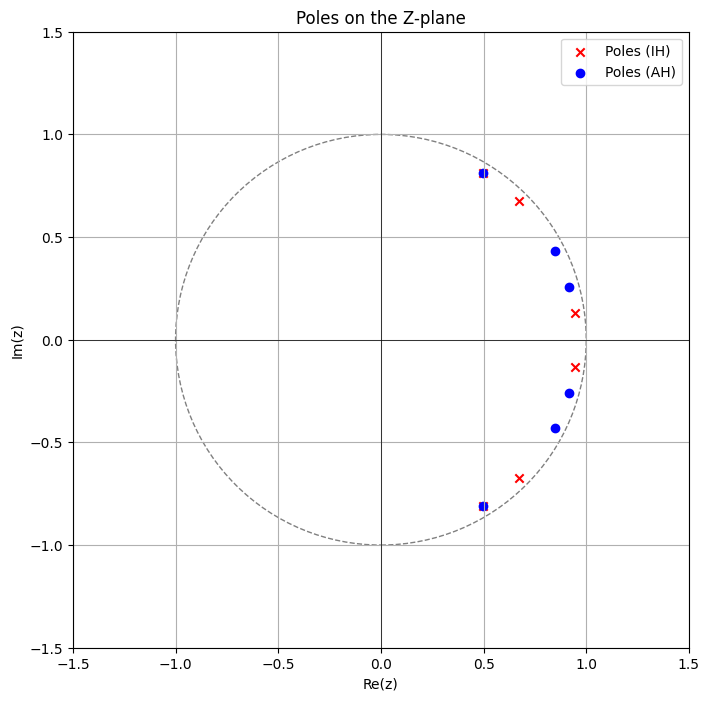

In [96]:
# Create the Z-plane plot
plt.figure(figsize=(8, 8))
# Plot poles for ih
plt.scatter(np.real(poles_ih), np.imag(poles_ih), color='red', label="Poles (IH)", marker='x')
# Plot poles for ah
plt.scatter(np.real(poles_ah), np.imag(poles_ah), color='blue', label="Poles (AH)", marker='o')
# Plot unit circle for reference
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
plt.gca().add_artist(circle)
# Labels and title
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.title("Poles on the Z-plane")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
# Show the plot
plt.show()

Una volta che ho i poli potrei procedere con la sintesi dei suoni vocali.

In [140]:
def create_impulse_train(T, f0, fs):
    # T = 2.0 # durata di 2 secondi
    # Genera l'eccitazione (treno di impulsi per la voce vocalizzata)
    t = np.arange(0, T, 1/fs) # treno di impulsi di durata T campionati con fs
    n_samples = len(t)
    pitch_period = int(fs / f0)  # periodo in campioni
    excitation = np.zeros(n_samples)
    for i in range(0, n_samples, pitch_period):
        if i < n_samples:
            excitation[i] = 1.0
    return excitation

In [141]:
def syntethize_from_formants(formants, B, fs, n_fft=1024, f0=80):
    '''
    Step:
    - calcolo dei poli
    - costruzione filtro lineare
    - generazione treno di impulsi
    - riproduzione audio
    '''
    poles = compute_poles(formants, B, fs)
    b, a = create_filter_from_poles(poles)
    print(f"Roots: {np.roots(a)}")
    excitation = create_impulse_train(T=0.5, f0=f0, fs=fs)
    # Applica il filtro all'eccitazione
    y = lfilter(b, a, excitation) # prende in input il guadagno (o una lista di guadagni), il filtro e il treno di impulsi
    y = np.real(y)
    plt.figure(figsize=(10, 4))
    plt.plot(t[:1000], y[:1000])  # Show the first samples for better visualization
    plt.xlabel("Tempo (s)")
    plt.ylabel("Ampiezza")
    plt.title("Segnale filtrato y(t)")
    plt.grid()
    plt.show()
    freq_response_plot(a, n_fft, fs, y)
    sd.play(y.squeeze(), fs)
    sd.wait(1)

Roots: [0.4974698 +0.81179693j 0.4974698 -0.81179693j 0.84832546+0.43224341j
 0.84832546-0.43224341j 0.91635164+0.25843789j 0.91635164-0.25843789j]


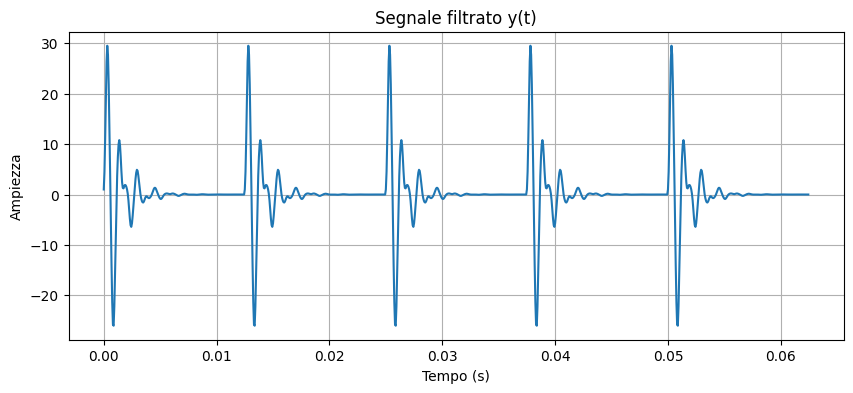

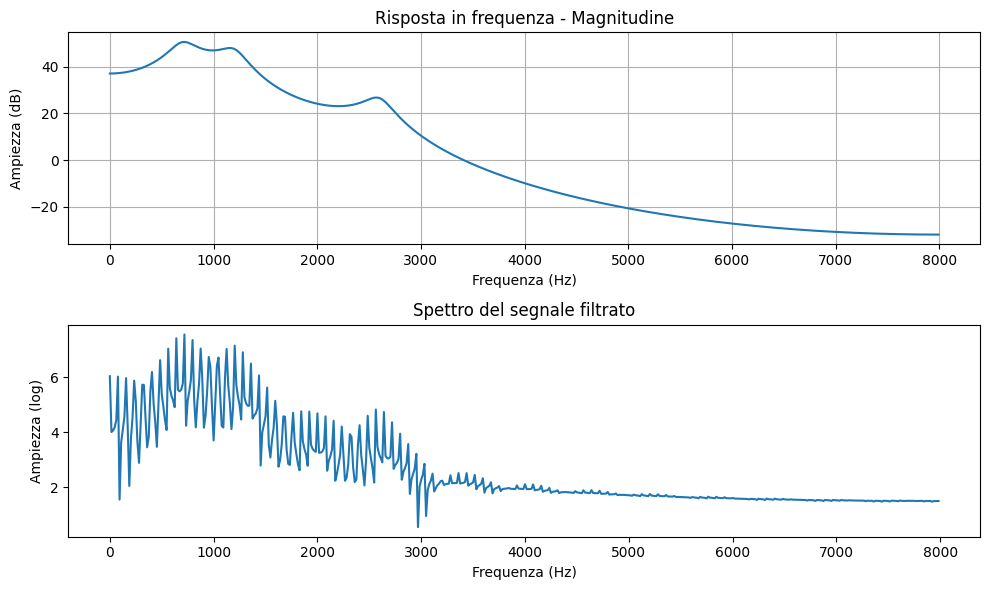

In [122]:
syntethize_from_formants(formants=formants_ah, B=B, fs=fs) # /ah/

Roots: [0.4974698 +0.81179693j 0.4974698 -0.81179693j 0.6732349 +0.6732349j
 0.6732349 -0.6732349j  0.94311902+0.13044917j 0.94311902-0.13044917j]


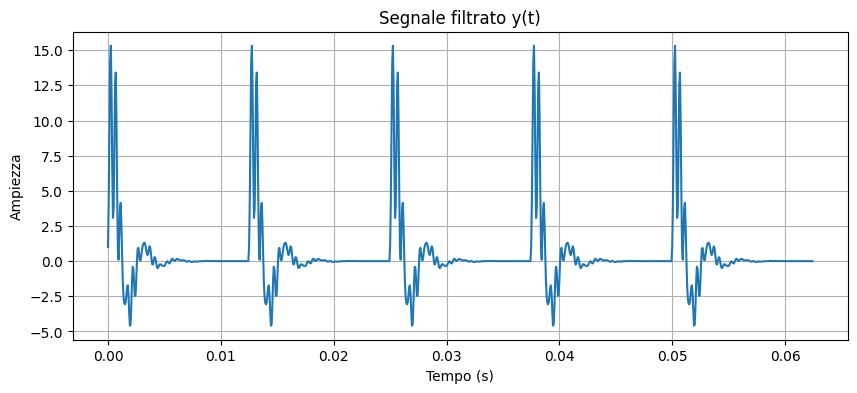

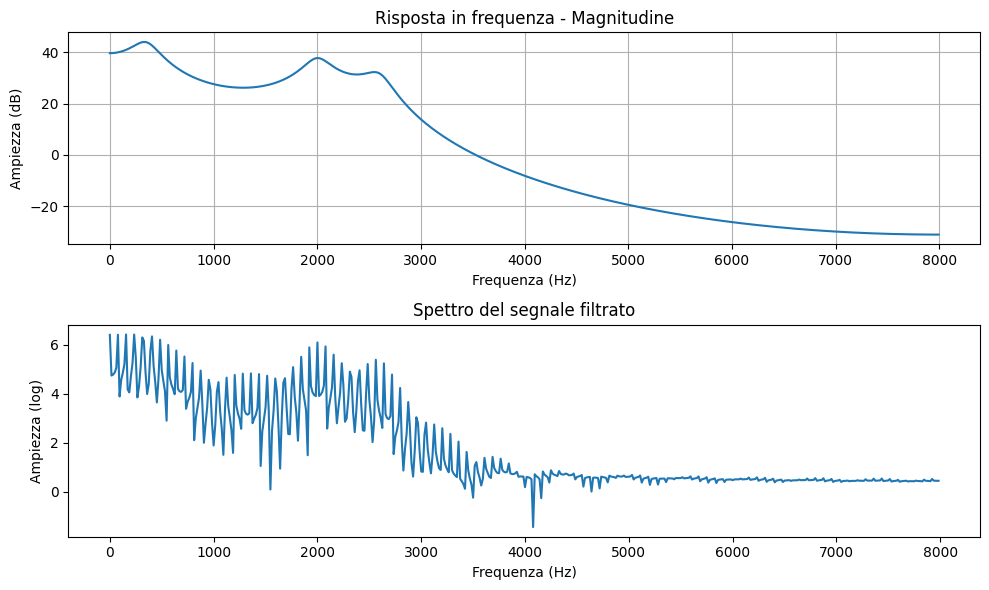

In [142]:
syntethize_from_formants(formants=formants_ih, B=B, fs=fs) # /ih/

Adesso facciamo lo stesso con le formanti delle vocali dell'alfabeto italiano

In [125]:
formants_a = [730, 1090, 2440]
formants_e = [600, 2000, 2700]
formants_i = [400, 2500, 3000]
formants_o = [500, 800, 2700]
formants_u = [300, 500, 2400]

Roots: [0.54746131+0.77895865j 0.54746131-0.77895865j 0.91324347+0.26921522j
 0.91324347-0.26921522j 0.86619988+0.39520657j 0.86619988-0.39520657j]


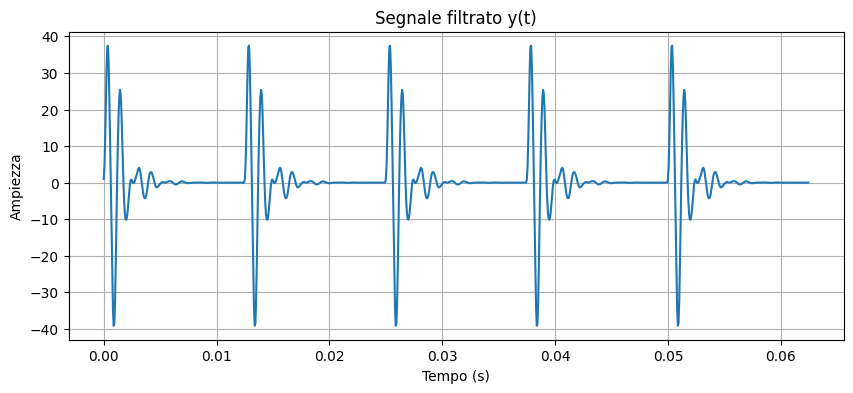

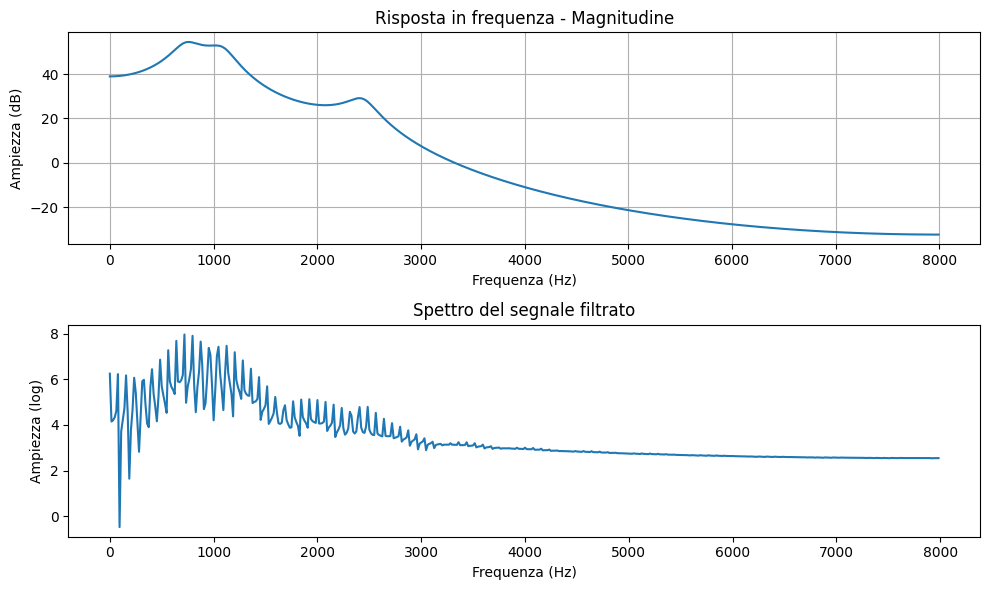

In [143]:
syntethize_from_formants(formants=formants_a, B=B, fs=fs)

Roots: [0.46521527+0.83070164j 0.46521527-0.83070164j 0.6732349 +0.6732349j
 0.6732349 -0.6732349j  0.92579139+0.22226285j 0.92579139-0.22226285j]


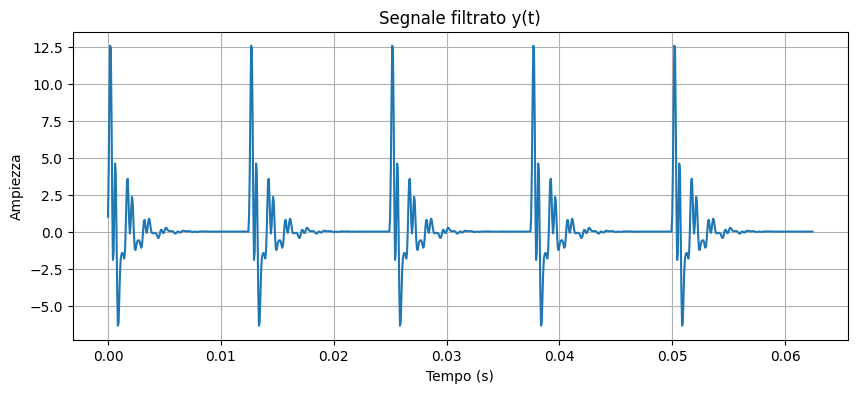

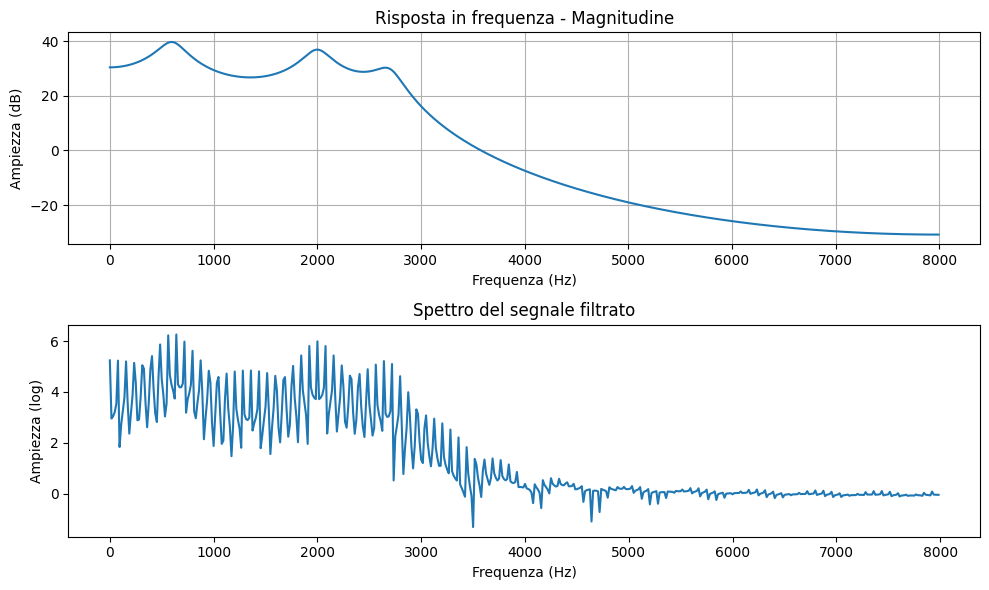

In [144]:
syntethize_from_formants(formants_e, B, fs)

Roots: [0.3643521 +0.87962379j 0.3643521 -0.87962379j 0.52895727+0.79164049j
 0.52895727-0.79164049j 0.94037602+0.14894093j 0.94037602-0.14894093j]


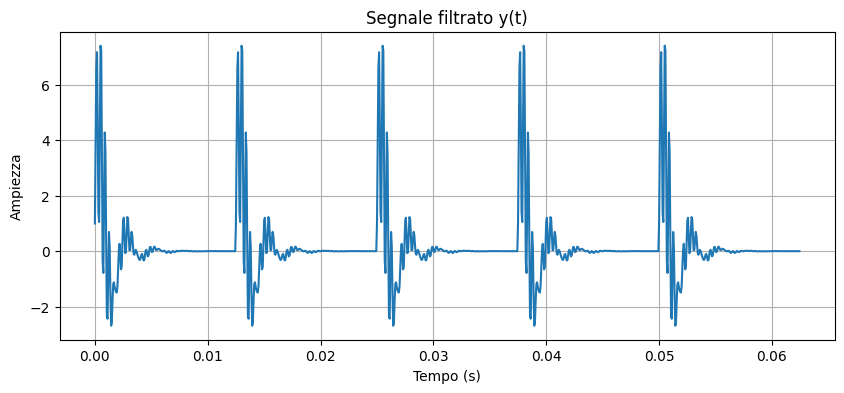

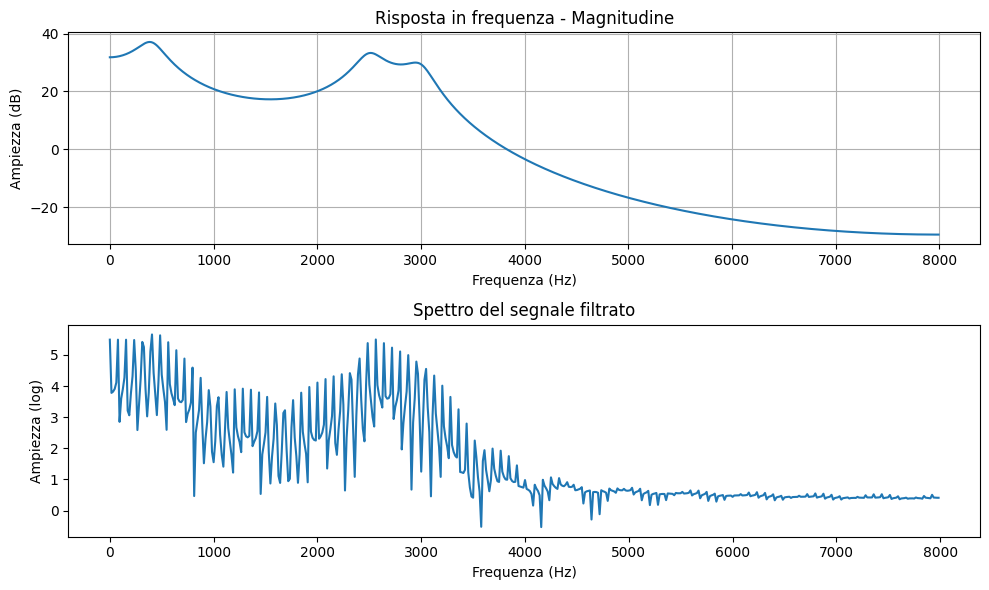

In [145]:
syntethize_from_formants(formants_i, B, fs)

Roots: [0.46521527+0.83070164j 0.46521527-0.83070164j 0.90549894+0.29421444j
 0.90549894-0.29421444j 0.93380363+0.18574509j 0.93380363-0.18574509j]


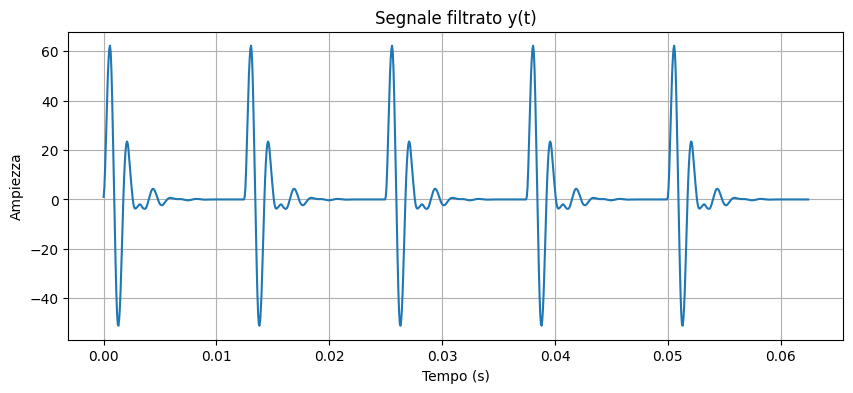

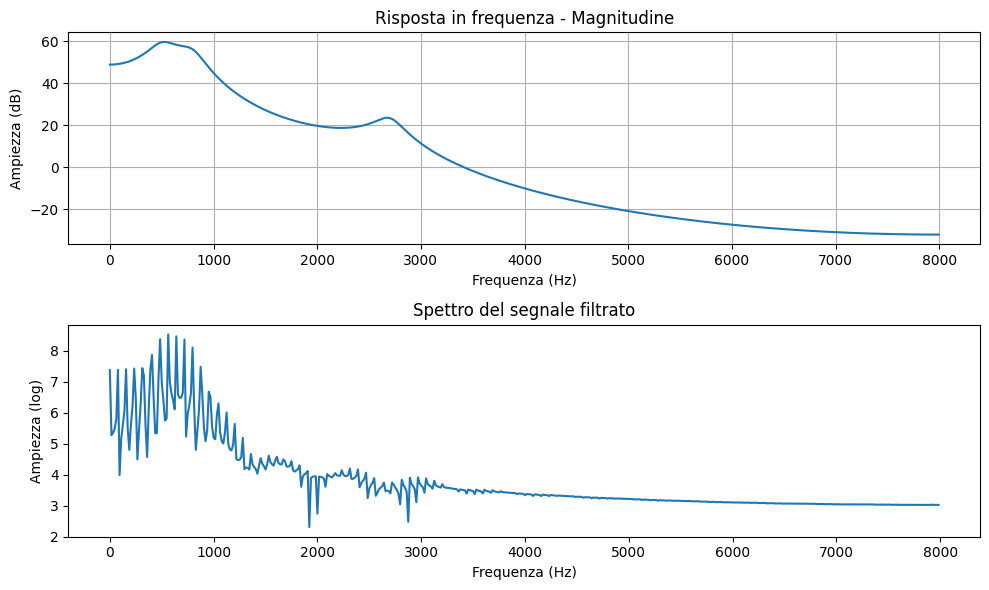

In [146]:
syntethize_from_formants(formants_o, B, fs)

Roots: [0.55962912+0.7702634j  0.55962912-0.7702634j  0.93380363+0.18574509j
 0.93380363-0.18574509j 0.94549842+0.11190711j 0.94549842-0.11190711j]


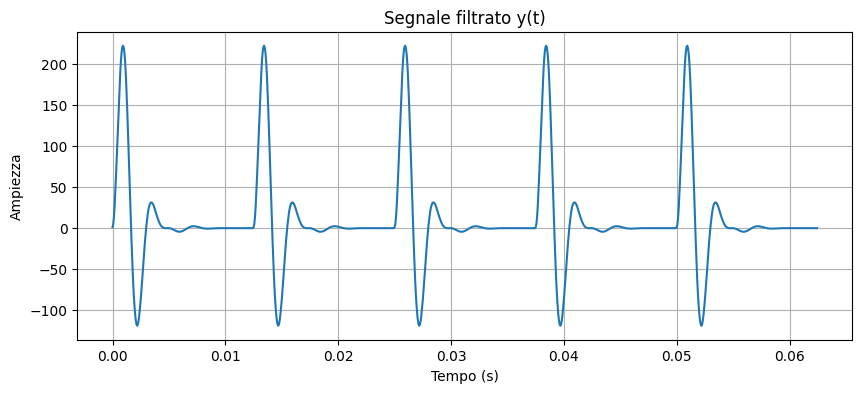

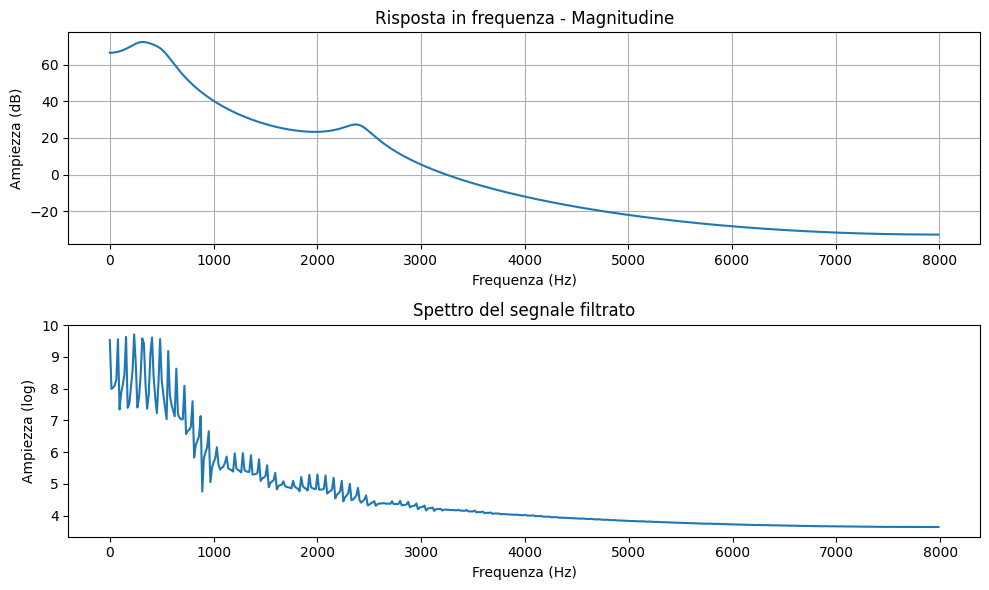

In [147]:
syntethize_from_formants(formants_u, B, fs)